# Bagging for data valuation

This notebook introduces the Data-OOB method, an implementation based on a publication from Kwon and Zou "[Data-OOB: Out-of-bag Estimate as a Simple and Efficient Data Value](https://proceedings.mlr.press/v202/kwon23e.html)" ICML 2023 , using pyDVL.


The objective of this paper is mainly to overcome the computational bottleneck of shapley-based data valuation methods that require to fit a significant number of models to accurately estimate marginal contributions.
The algorithms compute data values from out of bag estimates using a bagging model.

The value can be interpreted as a partition of the OOB estimate, which is originally introduced to estimate the prediction error. This OOB estimate is given as:

$$
\sum_{i=1}^n\frac{\sum_{b=1}^{B}\mathbb{1}(w_{bi}=0)T(y_i, \hat{f}_b(x_i))}{\sum_{b=1}^{B}
\mathbb{1}
(w_{bi}=0)}
$$


## Setup

We begin by importing the main libraries and setting some defaults.

<div class="alert alert-info">

If you are reading this in the documentation, some boilerplate (including most plotting code) has been omitted for convenience.

</div>

In [1]:
%load_ext autoreload

import os
import random
from concurrent.futures import FIRST_COMPLETED, wait
from typing import Literal

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from tqdm.notebook import tqdm
from support.common import load_adult_data

from pydvl.parallel import init_executor
from pydvl.reporting.plots import plot_ci_array, plot_ci_values
from pydvl.reporting.scores import compute_removal_score

matplotlib.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)

is_CI = os.environ.get("CI")
random_state = 24
random.seed(random_state)

/Users/kristof/Projects/pyDVL/src/pydvl/value/__init__.py:16: FutureWarning: The package pydvl.value was deprecated since v0.10.0 in favor of pydvl.valuation. It will be removed in v0.12.0.
  warnings.warn(msg, FutureWarning)


In [2]:
%autoreload
from pydvl.valuation import (
    ValuationResult,
    DataOOBValuation,
    Dataset,
    KNNClassifierUtility,
)
from pydvl.utils import Seed, ensure_seed_sequence

We will work with the [adult classification dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data) from the UCI repository. The objective is to predict whether a person earns more than 50k a year based on a set of features such as age, education, occupation, etc.

With a helper function we download the data and obtain the following pandas dataframe, where the categorical features have been removed:

In [3]:
data_adult = load_adult_data()

Found cached file: adult_data.pkl.


In [4]:
if is_CI:
    data_adult = data_adult.sample(100, random_state=random_state)

In [5]:
data_adult.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income
0,39,77516,13,2174,0,40,<=50K
1,50,83311,13,0,0,13,<=50K
2,38,215646,9,0,0,40,<=50K
3,53,234721,7,0,0,40,<=50K
4,28,338409,13,0,0,40,<=50K


## Computing the OOB values

The main idea of Data-OOB is to take an existing classifier or regression model and compute a per-sample out-of-bag performance estimate via bagging.

For this example, we use a simple KNN classifier with $k=5$ neighbours on the data and compute the data-oob values with two choices for the number of estimators in the bagging. For that we construct a [Utility][pydvl.utils.utility.Utility] object using the [Scorer][pydvl.utils.score.Scorer] class to specify the metric to use for the evaluation. Note how we pass a random seed to [Dataset.from_arrays][pydvl.utils.dataset.Dataset.from_arrays] in order to ensure that we always get the same split when running this notebook multiple times. This will be particularly important when running the standard point removal experiments later.

We then use the [compute_data_oob][pydvl.value.oob.compute_data_oob] function to compute the data-oob values.

In [6]:
train_data, test_data = Dataset.from_arrays(
    data_adult.drop(columns=["income"]).values,
    data_adult.loc[:, "income"].cat.codes.values,
    random_state=random_state,
)
model = KNeighborsClassifier(n_neighbors=5)

In [7]:
n_estimators = [100, 500]
oob_values = []
for n_est in n_estimators:
    valuation = DataOOBValuation(
        model, n_estimators=n_est, max_samples=0.95, seed=random_state
    )
    valuation.fit(train_data)
    oob_values.append(valuation.values())

Casting ValuationResult.names from object to object
Casting ValuationResult.names from object to object
Casting ValuationResult.names from object to object
Casting ValuationResult.names from object to object
Casting ValuationResult.names from object to object
Casting ValuationResult.names from object to object
Casting ValuationResult.names from object to object
Casting ValuationResult.names from object to object
Casting ValuationResult.names from object to object
Casting ValuationResult.names from object to object
Casting ValuationResult.names from object to object
Casting ValuationResult.names from object to object
Casting ValuationResult.names from object to object
Casting ValuationResult.names from object to object
Casting ValuationResult.names from object to object
Casting ValuationResult.names from object to object
Casting ValuationResult.names from object to object
Casting ValuationResult.names from object to object
Casting ValuationResult.names from object to object
Casting Valu

The two results are stored in an array of [ValuationResult][pydvl.value.result.ValuationResult] objects. Here's their distribution. The left-hand side depicts value as it increases with rank and a 99% t-confidence interval. The right-hand side shows the histogram of values.

Observe how adding estimators reduces the variance of the values, but doesn't change their distribution much. 

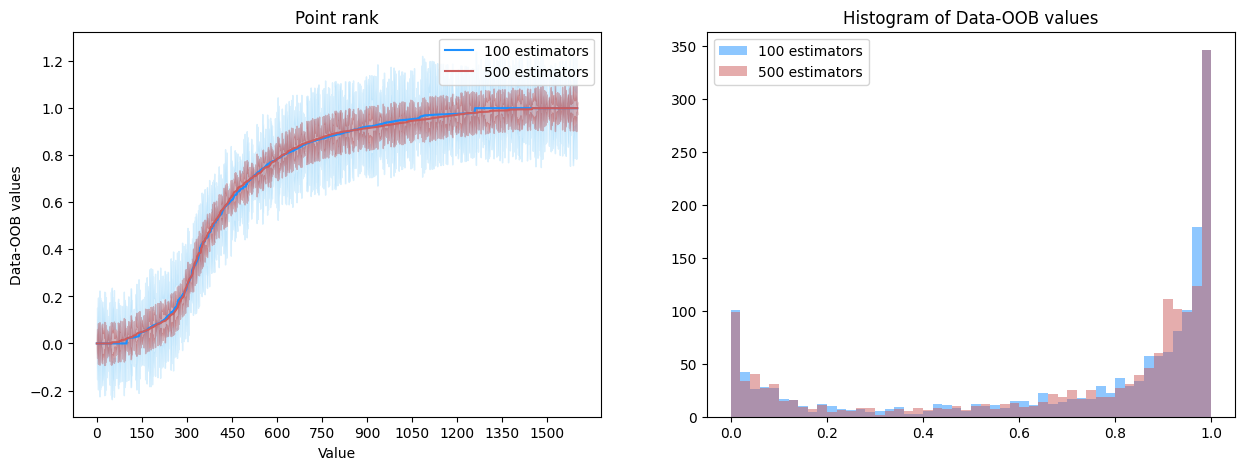

In [8]:
mean_colors = ["dodgerblue", "indianred", "limegreen", "darkorange", "darkorchid"]
shade_colors = ["lightskyblue", "firebrick", "seagreen", "gold", "plum"]
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[15, 5])

for (n_est, values, mean_color, shade_color) in zip(
    n_estimators, oob_values, mean_colors, shade_colors
):
    values.sort(key="value")
    plot_ci_values(
        values,
        level=0.01,
        mean_color=mean_color,
        shade_color=shade_color,
        ax=ax1,
        label=f"{n_est} estimators",
    )

    ax2.hist(values, bins=50, color=mean_color, alpha=0.5, label=f"{n_est} estimators")
ax1.set_title("Point rank")
ax1.set_xlabel("Value")
ax1.set_ylabel("Data-OOB values")
ax1.set_xticks(ax1.get_xticks()[::150])
ax1.legend()
ax2.set_title("Histogram of Data-OOB values")
ax2.legend()
plt.plot();

## Point removal experiments

The standard procedure for the evaluation of data valuation schemes is the point removal experiment. The objective is to measure the evolution of performance when the best/worst points are removed from the training set. This can be done with the function [compute_removal_score][pydvl.reporting.scores.compute_removal_score], which takes precomputed values and computes the performance of the model as points are removed.

In order to test the true performance of DataOOB, we repeat the whole task of computing the values and the point removal experiment multiple times, including the splitting of the dataset into training and valuation sets. It is important to remember to pass random state adequately for full reproducibility.

In [9]:
def removal_job(
    method: Literal["random", "oob"],
    seed: Seed,
    n_est: int = 500,
    max_samples: float = 0.95,
):
    """This is not very efficient, but it's just an example."""
    data = Dataset(
        data_adult.drop(columns=["income"]).values,
        data_adult.loc[:, "income"].cat.codes.values,
    )

    model = KNeighborsClassifier(n_neighbors=5)
    valuation = DataOOBValuation(
        model, n_estimators=n_est, max_samples=max_samples, seed=seed
    )

    if method == "random":
        values = ValuationResult.from_random(size=len(data), seed=seed)
    else:
        valuation.fit(data)
        values = valuation.values()

    best_scores = compute_removal_score(
        KNNClassifierUtility(model, data),
        values,
        data,
        percentages=removal_percentages,
        remove_best=True,
    )
    best_scores["method_name"] = values.algorithm

    worst_scores = compute_removal_score(
        KNNClassifierUtility(model, data),
        values,
        data,
        percentages=removal_percentages,
        remove_best=False,
    )
    worst_scores["method_name"] = values.algorithm

    return best_scores, worst_scores

In [10]:
n_runs = 20
max_workers = 12
seed = random_state

all_best_scores = []
all_worst_scores = []
removal_percentages = np.arange(0, 0.99, 0.01)

pending = set()

with init_executor(max_workers=max_workers) as executor:
    seed_seq = ensure_seed_sequence(seed)
    for i, seed_1, seed_2 in zip(
        range(n_runs), seed_seq.spawn(n_runs), seed_seq.spawn(n_runs)
    ):
        pending.add(executor.submit(removal_job, method="random", seed=seed_1))
        pending.add(
            executor.submit(
                removal_job, method="data_oob", n_est=500, max_samples=0.95, seed=seed_2
            )
        )

    pbar = tqdm(total=2 * n_runs, unit="%")
    while len(pending) > 0:
        pbar.n = 2 * n_runs - len(pending) + 1  # HACK
        pbar.refresh()
        completed, pending = wait(pending, timeout=0.5, return_when=FIRST_COMPLETED)
        for future in completed:
            best_scores, worst_scores = future.result()
            all_best_scores.append(best_scores)
            all_worst_scores.append(worst_scores)

best_scores_df = pd.DataFrame(all_best_scores)
worst_scores_df = pd.DataFrame(all_worst_scores)

/Users/kristof/Projects/pyDVL/src/pydvl/parallel/config.py:31: FutureWarning: The `ParallelConfig` class was deprecated in v0.9.0 and will be removed in v0.10.0
  warnings.warn(
/Users/kristof/Projects/pyDVL/src/pydvl/parallel/backends/joblib.py:79: FutureWarning: The `JoblibParallelBackend` uses deprecated arguments: `config`. They were deprecated since v0.9.0 and will be removed in v0.10.0.
  warnings.warn(


  0%|          | 0/40 [00:00<?, ?%/s]

/Users/kristof/Projects/pyDVL/src/pydvl/value/__init__.py:16: FutureWarning: The package pydvl.value was deprecated since v0.10.0 in favor of pydvl.valuation. It will be removed in v0.12.0.
  warnings.warn(msg, FutureWarning)
Casting ValuationResult.names from object to object
Casting ValuationResult.names from object to object
Casting ValuationResult.names from object to object
Casting ValuationResult.names from object to object
Casting ValuationResult.names from object to object
Casting ValuationResult.names from object to object
Casting ValuationResult.names from object to object
Casting ValuationResult.names from object to object
Casting ValuationResult.names from object to object
Casting ValuationResult.names from object to object
Casting ValuationResult.names from object to object
Casting ValuationResult.names from object to object
Casting ValuationResult.names from object to object
Casting ValuationResult.names from object to object
Casting ValuationResult.names from object to o

/opt/homebrew/Caskroom/miniforge/base/envs/pydvl/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/envs/pydvl/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/homebrew/Caskroom/miniforge/base/envs/pydvl/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/homebrew/Caskroom/miniforge/base/envs/pydvl/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/homebrew/Caskroom/miniforge/base/envs/pydvl/lib/python3.8/site-packages/numpy/core/_methods.py:258: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/

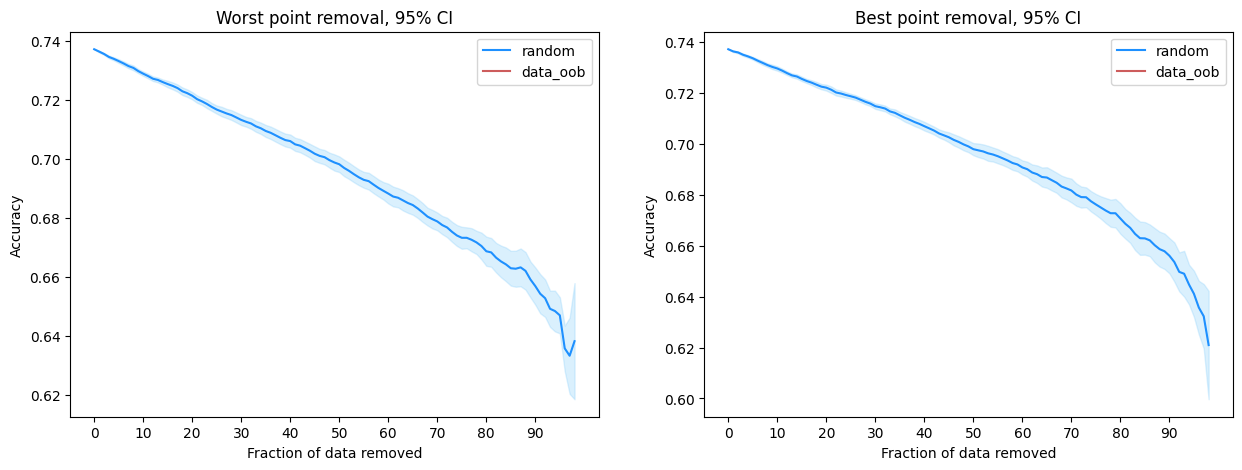

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[15, 5])

for i, method_name in enumerate(["random", "data_oob"]):
    plot_ci_array(
        data=worst_scores_df[worst_scores_df["method_name"] == method_name]
        .drop(columns=["method_name"])
        .values,
        level=0.05,
        abscissa=removal_percentages,
        mean_color=mean_colors[i],
        shade_color=shade_colors[i],
        label=method_name,
        ax=ax1,
    )
    plot_ci_array(
        best_scores_df[best_scores_df["method_name"] == method_name]
        .drop(columns=["method_name"])
        .values,
        level=0.05,
        abscissa=removal_percentages,
        mean_color=mean_colors[i],
        shade_color=shade_colors[i],
        label=method_name,
        ax=ax2,
    )
metric_name = "Accuracy"
ax1.set_title("Worst point removal, 95% CI")
ax1.set_xlabel("Fraction of data removed")
ax1.set_ylabel(metric_name)
ax1.set_xticks(ax1.get_xticks()[::10])
ax1.legend()
ax2.set_title("Best point removal, 95% CI")
ax2.set_xlabel("Fraction of data removed")
ax2.set_xticks(ax2.get_xticks()[::10])
ax2.set_ylabel(metric_name)
ax2.legend()

plt.show();